In [1]:
# Simulated BB clustering notebook using simple Acid set from Enamine.
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
#from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import kmedoids

import seaborn as sns
import umap

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_fingerprint(mol,radius,bits):
    try:
        fp=AllChem.GetMorganFingerprintAsBitVect(mol,radius,bits)
        return(fp)
    except:
        print(f'{mol} failed in RDkit')
        return (np.nan)

In [3]:
df = PandasTools.LoadSDF(filename = "Data/Enamine_Acids.sdf")
print(len(df))

# generate FPs
n=3
bits = 1024
df['fp'] = df['ROMol'].apply(lambda x: generate_fingerprint(x,n,bits))

995


In [4]:
# Calculate the Tanimoto distance matrix
distance_matrix = []
fp_list = df['fp'].to_list()
for i in range(len(fp_list)):
    row = []
    for j in range(len(fp_list)):
        # Calculate Tanimoto similarity
        similarity = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
        
        # Convert to Tanimoto distance
        distance = 1 - similarity
        row.append(distance)
    distance_matrix.append(row)

distance_matrix = np.array(distance_matrix)
X = np.stack(df.fp)

In [89]:
results = []
for i in range(5,50,3):
    km = kmedoids.pam(distance_matrix,i,random_state=42)
    labels = km.labels
    s_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    km_sil = kmedoids.silhouette(distance_matrix, labels)[0]
    results.append({'k_value':i, 'sil_score':s_score,'km_sil': km_sil, 'db_score': db_score})

<Axes: xlabel='k_value', ylabel='sil_score'>

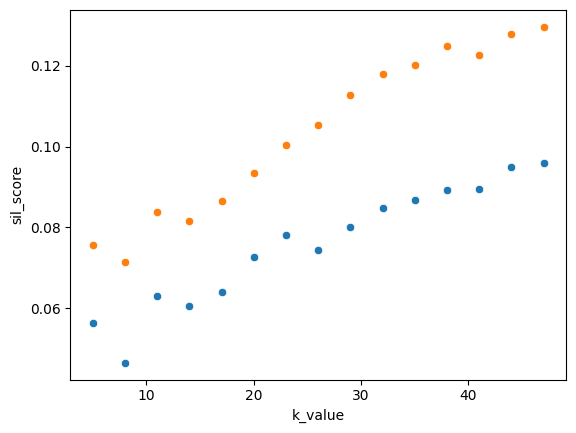

In [92]:
result_df = pd.DataFrame(results)
sns.scatterplot(data=result_df, x='k_value', y='sil_score')
sns.scatterplot(data=result_df, x='k_value', y ='km_sil')

<Axes: xlabel='k_value', ylabel='db_score'>

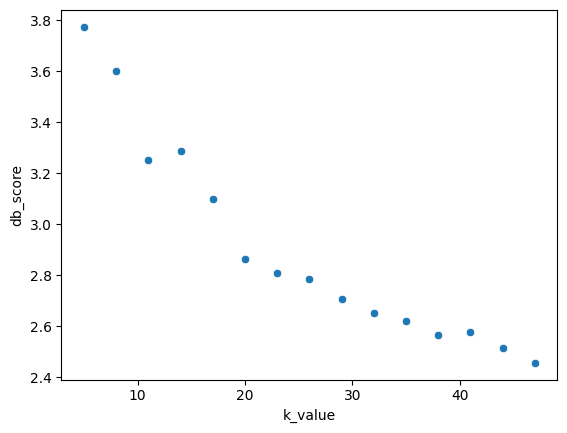

In [69]:
result_df = pd.DataFrame(results)
sns.scatterplot(data=result_df, x='k_value', y='db_score')

In [70]:
# Pick a reasonable number of clusters based on the scores & how many building blocks we would like
n= 40

In [71]:
km = kmedoids.pam(distance_matrix,n)

In [72]:
df['cluster'] = km.labels
df['mediod'] = [1 if i in km.medoids else 0 for i in range(len(df)) ]

/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/chemistry/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>

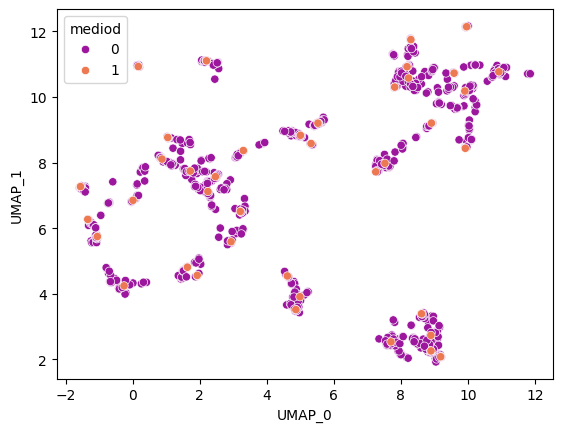

In [73]:
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = True,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(df['fp'].to_list())
df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

sns.scatterplot(data=df.sort_values(by='mediod'),x='UMAP_0',y='UMAP_1',hue='mediod', palette='plasma')

In [77]:
group_sizes = df.groupby('cluster').size()
group_sizes

cluster
0     16
1     63
2     42
3     53
4     43
5     60
6     35
7     48
8     19
9     10
10    31
11    38
12    20
13    25
14    23
15    16
16    13
17    38
18    20
19    28
20    16
21    12
22    25
23    24
24    18
25    19
26    19
27    17
28    14
29    39
30    24
31    14
32    10
33    13
34    10
35    17
36     7
37     8
38    36
39    12
dtype: int64

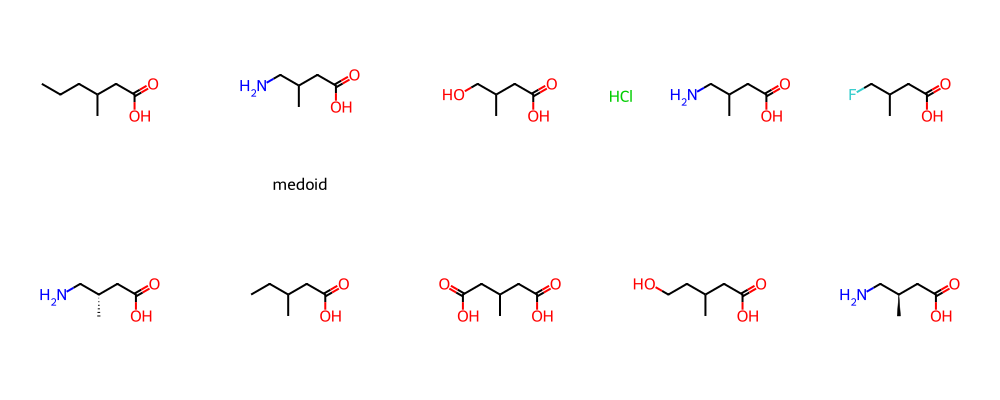

In [81]:
cluster= 9
Chem.Draw.MolsToGridImage(mols=df[df['cluster']==cluster]['ROMol'].to_list(),
                         legends=["medoid" if i==1 else "" for i in df[df['cluster']==cluster]['mediod']],
                         molsPerRow=5, subImgSize=(200, 200))